# Natural language processing - getting the sentiment score for positive, negative and unceratinty. Using Loughran and McDonalds' method

We are now going to move on to extracting the sentiment positive, negative and uncertainty scores for the transcripts.
We are going to use the dictionary developed by Loughran and McDonald, compared to other methods, this is developed within our field of academia.
A lot of other methods use dictionaries created from other data sources than financial texts, like social media. This will not be as suitable for our usecase.

This is because words otherwise seen as negative are not always in finance.
"We find that almost three-fourths of negative word counts in 10-K filings based on the Harvard dictionary are typically not negative in a financial context. Common words like depreciation, liability, foreign, and board are not tona when occurring in a 10-K." - Loughran, Tim, and Bill McDonald. "When is a liability not a liability? Textual analysis, dictionaries, and 10‐Ks.", The Journal of Finance 66, no. 1 (2011): 35-65.

In [1]:
# If you run into a spacy problem, run this command again by removing the # before the next row
#!python -m spacy download en_core_web_md 

In [2]:
# Spacy is a NLP library that can be used for a lot of things, 
# we are going to be using it to remove stopwords, punctuations and so on. 
import spacy
nlp=spacy.load('en_core_web_md')

/opt/app-root/src/.local/lib/python3.8/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_md' (3.1.0) was trained with spaCy v3.1.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## Lets import the transcripts again, and prepare one for analysis

In [3]:
import pickle
transcripts = pickle.load( open( str("../transcripts/AAPL.p"), "rb" ) )

In [4]:
text_transcipt = ''

# Here we loop through all statements, 
# here one could add a check if the person speaking is e.g. an analyst, 
# since the speach  object has a "name" attached to it as well. 
for speech in transcripts[1]['transcript']:
    # here we create a new string from the old string + the last statement (speach)
    # We add a space in between to prevent it from adding the first and last word together
    text_transcipt = text_transcipt + ' ' + speech['speech'][0] 

In [5]:
text_transcipt

" Good day everyone and welcome to the Apple Inc. Fourth Quarter Fiscal Year 2020 Earnings Conference Call. Today’s call is being recorded. At this time for opening remarks and introductions, I would like to turn things over to Tejas Gala, Senior Analyst, Corporate Finance and Investor Relations. Please go ahead, sir. Thank you. Good afternoon and thank you for joining us. Speaking first today is Apple’s CEO, Tim Cook, and he will be followed by CFO, Luca Maestri. After that, we’ll open the call to questions from analysts. Please note that some of the information you’ll hear during the discussion today, will consist of our forward-looking statements including without limitation those regarding revenue, gross margin, operating expenses, other income and expense, taxes, capital allocation and future business outlook, including the potential impact of COVID-19 on the company’s business, and results of operations. These statements involve risks and uncertainties that may cause actual resul

## How we prepare our text for analysis:¶

In [6]:
# Remove stop words, spaces, punctuation
# Lemmatize
# Convert to lower case
words=[
#     word
#     type(word)
#     word.lower_
#     type(word.lower_)
#     word.lemma_
#     type(word.lemma_)
#     (word.lower_, word.lemma_.lower())
    word.lemma_.lower()                 # Lemmatize and lower case
    for word in nlp(text_transcipt)   # Tokenize
    if not (
        word.is_space                   # Remove spaces
        or word.is_stop                 # Remove stop words
        or word.is_punct                # Remove punctuation
    )
]

# Lemmatize
print('Here are the first 100 words that are kept.')
print(words[:100])

Here are the first 100 words that are kept.
['good', 'day', 'welcome', 'apple', 'inc.', 'fourth', 'quarter', 'fiscal', 'year', '2020', 'earnings', 'conference', 'today', 'record', 'time', 'open', 'remark', 'introduction', 'like', 'turn', 'thing', 'tejas', 'gala', 'senior', 'analyst', 'corporate', 'finance', 'investor', 'relations', 'ahead', 'sir', 'thank', 'good', 'afternoon', 'thank', 'join', 'speak', 'today', 'apple', 'ceo', 'tim', 'cook', 'follow', 'cfo', 'luca', 'maestri', 'open', 'question', 'analyst', 'note', 'information', 'hear', 'discussion', 'today', 'consist', 'forward', 'look', 'statement', 'include', 'limitation', 'revenue', 'gross', 'margin', 'operating', 'expense', 'income', 'expense', 'taxis', 'capital', 'allocation', 'future', 'business', 'outlook', 'include', 'potential', 'impact', 'covid-19', 'company', 'business', 'result', 'operation', 'statement', 'involve', 'risk', 'uncertainty', 'cause', 'actual', 'result', 'trend', 'differ', 'materially', 'forecast', 'informati

### Explanation:
* Tokenization and Stop Word Removal: The code starts by tokenizing the input text using nlp(text_transcript), which breaks the text into individual tokens (words and punctuation marks). 

These tokens are then filtered to exclude unwanted elements:
* <u>word.is_space</u>: This checks whether the token is a space or a newline, and if it is, it is excluded from further processing.
* <u>word.is_stop</u>: This condition filters out common stop words such as "the", "and", "is", which are generally not useful in most NLP tasks since they don’t add significant meaning.
* word.is_punct: This removes punctuation marks, ensuring only meaningful words are kept for further analysis.
* <u>Lemmatization and Lowercasing</u>: After filtering, the remaining tokens are lemmatized using word.lemma_. Lemmatization reduces each word to its base or dictionary form (e.g., "running" becomes "run"). This helps in treating different inflections of the same word as a single entity. *
* After lemmatization, the words are also converted to lowercase with word.lemma_.lower(), ensuring consistency in analysis and avoiding case sensitivity issues.

List Comprehension: The entire process of filtering and transforming the tokens is performed in a Python list comprehension. For each word in the tokenized text, the code checks if it is a space, stop word, or punctuation, and if it passes these conditions, it adds the lowercased lemma of the word to the list. The result is a clean list of meaningful, lowercase, lemmatized words.

## Lets create a function that does this, so we do not have to write all this code more times.

In [7]:
# Putting all in a function so that we can use it later 
def process_text(text):
    # Tokenize
    # Remove stop words, spaces, punctuation
    # Lemmatize
    # Convert to lower case
    words=[
        word.lemma_.lower()                 # Lemmatize and lower case
        for word in nlp(text)          # Tokenize
        if not (
            word.is_space                   # Remove spaces
            or word.is_stop                 # Remove stop words
            or word.is_punct                # Remove punctuation
        )
    ]
    return words

### What does the function do? 
Let's test it with a very simple string to check

In [8]:
process_text('Hi and welcome to the earnings conference call of Apple')

['hi', 'welcome', 'earning', 'conference', 'apple']

If we want to do anything with what the function returns, we have to save it in a variable:

In [9]:
apple_word_list = process_text('Hi and welcome to the earnings conference call of Apple')

In [10]:
apple_word_list

['hi', 'welcome', 'earning', 'conference', 'apple']

### We need to save the amount of words for later. 
So that we can turn X positive words into a ratio of total words

In [11]:
# We the save the amount of words for later. This will show us how many % of the words are e.g. positive. 
number_of_words=len(words)
number_of_words

3992

# Getting the Loughran & McDonald word list 

In [12]:
import pandas as pd
LM_negative=pd.read_excel('LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Negative', header=None)
LM_positive=pd.read_excel('LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Positive', header=None)
LM_uncertainty=pd.read_excel('LoughranMcDonald_SentimentWordLists_2018.xlsx', sheet_name='Uncertainty', header=None)

In [13]:
# A sample of what the uncertain words are
LM_uncertainty[11:16]

,0
11,ANOMALY
12,ANTICIPATE
13,ANTICIPATED
14,ANTICIPATES
15,ANTICIPATING


### We need to prepare the word lists

Lets go through it step by step:

In [14]:
# 1. We transpose the dataframe so that we can grab the words a list
LM_positive.T

,0,1,2,3,4,5,6,7,8,9,...,344,345,346,347,348,349,350,351,352,353
0,ABLE,ABUNDANCE,ABUNDANT,ACCLAIMED,ACCOMPLISH,ACCOMPLISHED,ACCOMPLISHES,ACCOMPLISHING,ACCOMPLISHMENT,ACCOMPLISHMENTS,...,VALUABLE,VERSATILE,VERSATILITY,VIBRANCY,VIBRANT,WIN,WINNER,WINNERS,WINNING,WORTHY


In [15]:
# 2. We grab only the values, it is no longer a pandas dataframe
LM_positive.T.values

array([['ABLE', 'ABUNDANCE', 'ABUNDANT', 'ACCLAIMED', 'ACCOMPLISH',
        'ACCOMPLISHED', 'ACCOMPLISHES', 'ACCOMPLISHING',
        'ACCOMPLISHMENT', 'ACCOMPLISHMENTS', 'ACHIEVE', 'ACHIEVED',
        'ACHIEVEMENT', 'ACHIEVEMENTS', 'ACHIEVES', 'ACHIEVING',
        'ADEQUATELY', 'ADVANCEMENT', 'ADVANCEMENTS', 'ADVANCES',
        'ADVANCING', 'ADVANTAGE', 'ADVANTAGED', 'ADVANTAGEOUS',
        'ADVANTAGEOUSLY', 'ADVANTAGES', 'ALLIANCE', 'ALLIANCES',
        'ASSURE', 'ASSURED', 'ASSURES', 'ASSURING', 'ATTAIN', 'ATTAINED',
        'ATTAINING', 'ATTAINMENT', 'ATTAINMENTS', 'ATTAINS',
        'ATTRACTIVE', 'ATTRACTIVENESS', 'BEAUTIFUL', 'BEAUTIFULLY',
        'BENEFICIAL', 'BENEFICIALLY', 'BENEFIT', 'BENEFITED',
        'BENEFITING', 'BENEFITTED', 'BENEFITTING', 'BEST', 'BETTER',
        'BOLSTERED', 'BOLSTERING', 'BOLSTERS', 'BOOM', 'BOOMING',
        'BOOST', 'BOOSTED', 'BREAKTHROUGH', 'BREAKTHROUGHS', 'BRILLIANT',
        'CHARITABLE', 'COLLABORATE', 'COLLABORATED', 'COLLABORATES',
      

In [16]:
# The function tolist() ensures we have a list. 
LM_positive.T.values.tolist()

[['ABLE',
  'ABUNDANCE',
  'ABUNDANT',
  'ACCLAIMED',
  'ACCOMPLISH',
  'ACCOMPLISHED',
  'ACCOMPLISHES',
  'ACCOMPLISHING',
  'ACCOMPLISHMENT',
  'ACCOMPLISHMENTS',
  'ACHIEVE',
  'ACHIEVED',
  'ACHIEVEMENT',
  'ACHIEVEMENTS',
  'ACHIEVES',
  'ACHIEVING',
  'ADEQUATELY',
  'ADVANCEMENT',
  'ADVANCEMENTS',
  'ADVANCES',
  'ADVANCING',
  'ADVANTAGE',
  'ADVANTAGED',
  'ADVANTAGEOUS',
  'ADVANTAGEOUSLY',
  'ADVANTAGES',
  'ALLIANCE',
  'ALLIANCES',
  'ASSURE',
  'ASSURED',
  'ASSURES',
  'ASSURING',
  'ATTAIN',
  'ATTAINED',
  'ATTAINING',
  'ATTAINMENT',
  'ATTAINMENTS',
  'ATTAINS',
  'ATTRACTIVE',
  'ATTRACTIVENESS',
  'BEAUTIFUL',
  'BEAUTIFULLY',
  'BENEFICIAL',
  'BENEFICIALLY',
  'BENEFIT',
  'BENEFITED',
  'BENEFITING',
  'BENEFITTED',
  'BENEFITTING',
  'BEST',
  'BETTER',
  'BOLSTERED',
  'BOLSTERING',
  'BOLSTERS',
  'BOOM',
  'BOOMING',
  'BOOST',
  'BOOSTED',
  'BREAKTHROUGH',
  'BREAKTHROUGHS',
  'BRILLIANT',
  'CHARITABLE',
  'COLLABORATE',
  'COLLABORATED',
  'COLLABORATE

In [17]:
LM_positive=LM_positive.T.values.tolist()[0]
LM_negative=LM_negative.T.values.tolist()[0]
LM_uncertainty=LM_uncertainty.T.values.tolist()[0]
len(LM_positive), len(LM_negative), len(LM_uncertainty)

(354, 2355, 297)

In [18]:
LM_positive=process_text(' '.join(LM_positive))
LM_negative=process_text(' '.join(LM_negative))
LM_uncertainty=process_text(' '.join(LM_uncertainty))
len(LM_positive), len(LM_negative), len(LM_uncertainty)

(354, 2353, 288)

Here you see a set(). This is another type of list used to make the process of extracting what positive, negative and uncertain words are in the the text. It also remove duplicates, which we have and need to remove.

In [19]:
LM_positive=set(process_text(' '.join(LM_positive)))
LM_negative=set(process_text(' '.join(LM_negative)))
LM_uncertainty=set(process_text(' '.join(LM_uncertainty)))
len(LM_positive), len(LM_negative), len(LM_uncertainty)

(239, 1341, 194)

We are going to use <code>Counters</code> and <code>Sets</code> to find out how many times the words are mentioend. 

In [20]:
from collections import Counter

In [21]:
# How many times are each word used
counts=Counter(words)
counts

Counter({'good': 16,
         'day': 4,
         'welcome': 1,
         'apple': 51,
         'inc.': 1,
         'fourth': 1,
         'quarter': 73,
         'fiscal': 8,
         'year': 60,
         '2020': 5,
         'earnings': 1,
         'conference': 2,
         'today': 16,
         'record': 34,
         'time': 43,
         'open': 5,
         'remark': 5,
         'introduction': 2,
         'like': 21,
         'turn': 6,
         'thing': 21,
         'tejas': 3,
         'gala': 1,
         'senior': 1,
         'analyst': 3,
         'corporate': 1,
         'finance': 1,
         'investor': 3,
         'relations': 1,
         'ahead': 7,
         'sir': 1,
         'thank': 29,
         'afternoon': 4,
         'join': 4,
         'speak': 5,
         'ceo': 1,
         'tim': 9,
         'cook': 1,
         'follow': 10,
         'cfo': 1,
         'luca': 11,
         'maestri': 1,
         'question': 14,
         'note': 1,
         'information': 5,
         '

In [22]:
# And here are all the words, not including the information about how many times they are included
keys=set(counts.keys())
keys

{'macs',
 'believe',
 '1',
 'rework',
 'join',
 '18',
 'draw',
 'human',
 'run',
 'welcome',
 'late',
 'debt',
 'company',
 'difference',
 'operating',
 'durability',
 'purchase',
 'launch',
 'dig',
 'uncertain',
 'pledge',
 'input',
 'incentive',
 '75',
 'manufacturing',
 'charge',
 'scanner',
 'public',
 'place',
 'invariably',
 'usage',
 'somewhat',
 'bond',
 'enthusiastic',
 'couple',
 'category',
 'news',
 'geographically',
 '888',
 'commit',
 'unprecedented',
 'entirely',
 'camera',
 'working',
 'marketable',
 'want',
 'pretty',
 'taxis',
 'doj',
 'have',
 'opex',
 'future',
 'favorite',
 'delighted',
 'canada',
 'similar',
 'factor',
 'billy',
 'holiday',
 'growth',
 'current',
 'renewable',
 'ship',
 'step',
 'wait',
 'exclude',
 'generation',
 'alike',
 'plus',
 'quick',
 'essentially',
 'fintech',
 'release',
 'stimulus',
 'kyle',
 'output',
 'important',
 'test',
 '1112',
 'question',
 'photography',
 '200',
 'designing',
 'information',
 '22',
 'constrained',
 'software',
 

Now here we get to where the <code>set()</code> shines. We can simply use the following to get the words that are in both. 

In [23]:
# This is where the set() shines
# Because keys and LM_negative are sets we can use the "&" and it will return what words mentioned that are in the LM_negative dictionary
keys & LM_negative

{'absence',
 'antitrust',
 'bad',
 'challenge',
 'closing',
 'closure',
 'concern',
 'confusion',
 'crisis',
 'critical',
 'critically',
 'cut',
 'delay',
 'difficult',
 'disruption',
 'fail',
 'fear',
 'force',
 'lag',
 'late',
 'limitation',
 'lose',
 'miss',
 'negative',
 'obstacle',
 'pervasive',
 'press',
 'problem',
 'question',
 'shortage',
 'shrinkage',
 'suspect',
 'volatile',
 'weakness'}

In [24]:
# This is where the set() shines. This would be a much heavier task on your computer if we didn't use sets. 
pos=sum([counts[k] for k in (keys & LM_positive)])
neg=sum([counts[k] for k in (keys & LM_negative)])
unc=sum([counts[k] for k in (keys & LM_uncertainty)])

pos, neg, unc

(172, 54, 31)

In [25]:
# Lets round these number since they will have very many decimals otherwise
# Again, there is nothing forcing you to use the score divided by the total number of words. 
# It's one way, if you think you have a better approach, test it! 
pos_score = round((pos / number_of_words), 4)
neg_score = round((neg / number_of_words), 4)
unc_score = round((unc / number_of_words), 4)
pos_score, neg_score, unc_score

(0.0431, 0.0135, 0.0078)

## Now we are done and have extracted a score for pos, neg and unc. for the transcript. In the next part we will look at how to put this into functions letting us do it for a bunch of transcripts at once. 

In [26]:
# We're going to need to know what score is from what time, we can do the following to get this information
transcripts[0]['time']

'2021-01-28 01:49:07'


Now we can create a loop that creates to lists, one with the dates and one with the complete texts. Here is where you could get creative later when changing if you look at only CEO or only analysts and so on.

In [27]:
transcripts_texts = []

# We also create an array of all dates that we can add in the end to know when each earnings call was held.
times = []

for t in transcripts:
    text = ''
    for speech in t['transcript']:
        text = str(text + ' '+ speech['speech'][0])

    transcripts_texts.append(text)
    
    times.append(t['time'])
    
len(transcripts_texts), len(times)

(63, 63)

Now that we see that they are the same length, we know that the score at index 10 will be for the time at index 10.

### Now that we have prepared the data, lets create another function that completes the process of scoring a transctip which will enable us to loop through them all and get scores.

The servers we have do not have enough memory for some transcripts that are extremply long. So we've implemented an easy fix to prevent the notebooks from crashing, if the transcripts are more than X words, then only save the X first words. We've used 80.000 here which has worked well before, but you are free to test if you can increase it. 

In [28]:
def score_transcript(text):
    # Fix to prevent notebook from crashing
    if len(text) > 80_000:
        text = text[:80_000] # Only save the X first words. 
    
    
    # Running the function we created earlier that remove stopwords, spaces and so on... 
    words = process_text(text)

        
    # This is the same as above as well. 
    # We the save the amount of words for later. This will show us how many % of the words are e.g. positive. 
    number_of_words=len(words)
    
    counts=Counter(words)

    keys=set(counts.keys())

    pos = round((sum([counts[k] for k in (keys & LM_positive)]) / number_of_words), 4)
    neg = round((sum([counts[k] for k in (keys & LM_negative)]) / number_of_words), 4)
    unc = round((sum([counts[k] for k in (keys & LM_uncertainty)]) / number_of_words), 4)
    
    return(pos, neg, unc)

In [29]:
# If you want to run a test and not run through all (which will take time) do this,
# and it will only run on 4 instead of all transctips 
#transcripts_texts = transcripts_texts[:4]

In [30]:
import numpy as np
# Let's create a dataframe to save all scores.
sentiment_scores = pd.DataFrame(columns=['pos', 'neg', 'unc'])

# Loop through all texts 
for texts in transcripts_texts:
    # Calls our scoring function and gets 3 scores back
    scores = score_transcript(texts)
    
    # This creates a new dataframe with one line of 3 scores 
    # and adds it to the bottom of our dataframe that stores all scores
    sentiment_scores = pd.concat([sentiment_scores, pd.DataFrame([np.array(scores)], columns=['pos', 'neg', 'unc'])]).reset_index(drop=True)

In [31]:
sentiment_scores

,pos,neg,unc
0,0.0449,0.0196,0.0124
1,0.0431,0.0135,0.0078
2,0.0404,0.0195,0.0100
3,0.0309,0.0371,0.0108
4,0.0343,0.0221,0.0092
...,...,...,...
58,0.0325,0.0228,0.0074
59,0.0386,0.0267,0.0100
60,0.0378,0.0244,0.0091
61,0.0301,0.0241,0.0102


Lets now add the dates in.

In [32]:
sentiment_scores.index = pd.to_datetime(times)

# Lets also reverse the order so that old is first. Makes it easier to merge. 
# https://stackoverflow.com/a/3940137
sentiment_scores = sentiment_scores[::-1]

sentiment_scores

,pos,neg,unc
2006-01-19 13:53:17,0.0275,0.0241,0.0122
2006-04-20 11:01:29,0.0301,0.0241,0.0102
2006-07-20 00:49:46,0.0378,0.0244,0.0091
2006-10-19 04:57:25,0.0386,0.0267,0.0100
2007-01-18 03:24:19,0.0325,0.0228,0.0074
...,...,...,...
2020-01-29 02:36:45,0.0343,0.0221,0.0092
2020-05-01 01:52:14,0.0309,0.0371,0.0108
2020-07-31 03:36:08,0.0404,0.0195,0.0100
2020-10-30 03:41:57,0.0431,0.0135,0.0078


<Axes: >

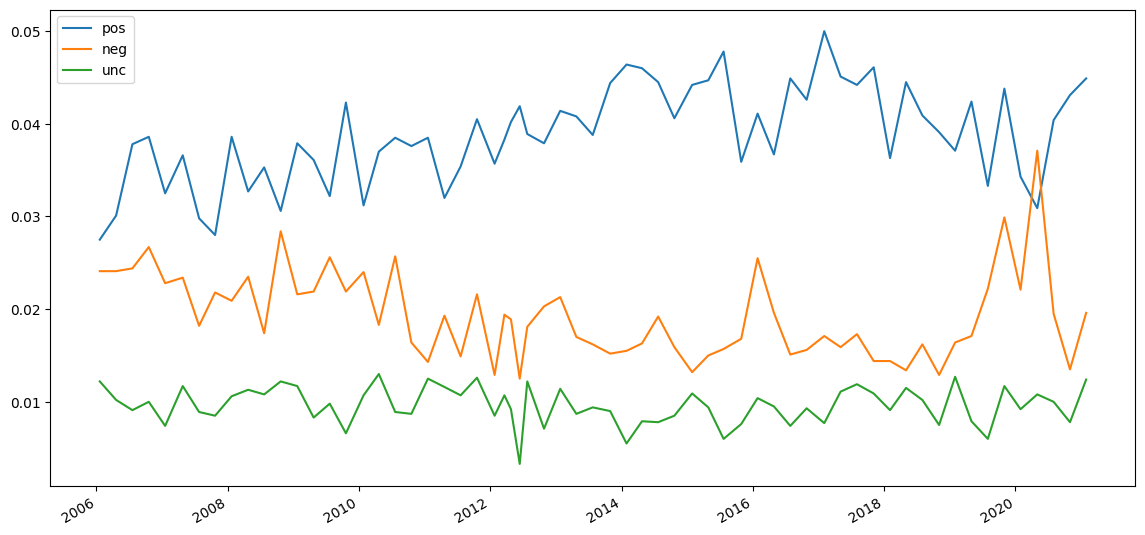

In [33]:
sentiment_scores.plot(figsize=(14,7))

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the correlation matrix
correlation_matrix = sentiment_scores.corr()
correlation_matrix

,pos,neg,unc
pos,1.000000,-0.49193,-0.213438
neg,-0.491930,1.00000,0.268320
unc,-0.213438,0.26832,1.000000


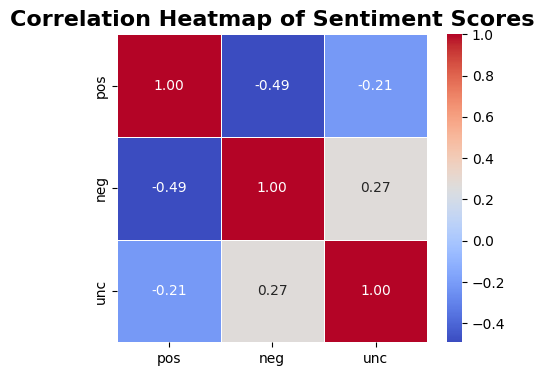

In [35]:
# Set up the matplotlib figure
plt.figure(figsize=(5, 4))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")

# Add a title
plt.title('Correlation Heatmap of Sentiment Scores', fontsize=16, fontweight='bold')

# Show the plot
plt.show()

# Lets quickly get some market data and plot the returns and share price in the same plot. 

In [36]:
import pandas_datareader as pdr

# Get the first date we have a sentiment scores and get market data from that date
date_start = sentiment_scores.index[0] # We can use -1 to get the last itam in a list. 

market_data = pdr.DataReader('AAPL', 
                   start=date_start, 
                   data_source='yahoo')

market_data['returns'] = market_data['Adj Close'] - market_data['Adj Close'].shift(1)

market_data = market_data[['Adj Close', 'returns']].dropna() # We only care about the closing price. And lets drop nans while we are at it

market_data.index = pd.to_datetime(market_data.index)

market_data

RemoteDataError: Unable to read URL: https://finance.yahoo.com/quote/AAPL/history?period1=1137693197&period2=1727841599&interval=1d&frequency=1d&filter=history
Response Text:
b'<html><meta charset=\'utf-8\'><script>if(window!=window.top){document.write(\'<p>Content is currently unavailable.</p><img src="//geo.yahoo.com/p?s=1197757039&t=\'+new Date().getTime()+\'&_R=\'+encodeURIComponent(document.referrer)+\'&err=404&err_url=\'+\'https%3A%2F%2Fbrb.yahoo.net%3A443%2Ffinance.yahoo.com%2Fdesktop%2Fquote%2FAAPL%2Fhistory%2Findex.html\'+\'" width="0px" height="0px"/>\');}else{window.location.replace(\'https://www.yahoo.com/?err=404&err_url=https%3A%2F%2Fbrb.yahoo.net%3A443%2Ffinance.yahoo.com%2Fdesktop%2Fquote%2FAAPL%2Fhistory%2Findex.html\');}</script><noscript><META http-equiv="refresh" content="0;URL=\'https://www.yahoo.com/?err=404&err_url=https%3A%2F%2Fbrb.yahoo.net%3A443%2Ffinance.yahoo.com%2Fdesktop%2Fquote%2FAAPL%2Fhistory%2Findex.html\'"></noscript></html>'

In [ ]:
# Let's merge the data to put it into the same time intervals.
plot_data = pd.merge_asof(sentiment_scores, market_data, left_index=True, right_index=True).dropna()
plot_data

In [ ]:
import matplotlib.pyplot as plt 

fig,ax = plt.subplots(figsize=(20, 10))

ax.plot(plot_data[['pos', 'neg', 'unc']])
# set x-axis label
ax.set_xlabel("year",fontsize=14)
# set y-axis label
ax.set_ylabel("Sentiment scores",color="red",fontsize=14)

# Here, since we have the same timespan but different intervals in the data, we share the X axis 
# But we create another y axis
ax2=ax.twinx()
ax2.plot(plot_data['Adj Close'], color='black', linewidth=3)
ax2.set_ylabel("Share Price",color="black", fontsize=14)

# And another y axis
ax3=ax.twinx()
ax3.plot(plot_data['returns'], color='red', linewidth=3)
ax3.set_ylabel("Returns",color="black", fontsize=14)

# if we want to log the closing price since it goes over such a long time we can by removinh comment. 
#plt.yscale('log')

fig.figsize=(30,15)

## Do not use this Cart as it is! Too much info in one and ontop of each other! This is to get you started, make it look better if you want to use it

Not necessarily the most informative plot <b>make sure yours look better!</b>. The goal was to give you an exmaple of how you can plot data using more than one axis, to plot data thats rather different in the same plot. Go look at the Visualisation material and make a more informative presentation.  

# What could be done to improve this?
Let's have a quick discussion about what you could do to improve this? 

* As I've written about before, now it's up to you to get creative, which is a huge parts of data analysis. 
    * Make some changes, like only analyze only what the analysts are saying and get a scores from that. 
    * Or lay the data we've used extracted over a fitting index
    
Come up with some creative ideas and start working on them. We'll try to help!

Since this is a part of what you'll be doing in the individual assignment, you might as well start now and get familliar with your data, your company and what possibilities for analysis you have. 

# Remember that you can use some of the info you've got about loops and functions to create a list and a function that scores all your tickers at once. You do not need to run this notebook one time for every ticker. But you'll have to write that loop and function.

I'm not 100% sure your severs will be able to do it without crashing but try ;)